## Homework exercise - Easter challange

<img src="https://storage.googleapis.com/hoopla/production/image/37941/IC2067501_l.jpg" alt="Eastyer challenge" width="400" align="center"/>

In this exercise you will need to program a code, that will chain deformation, erosion and heat transfer. Just remember, that for erosion you have to interpolate from deformed coordinates.... 

Happy coding... and let's see whether Mr. George Barrow would be surprised.

### Tracking P-T-t evolution in *“Naive orogeny”*

Create program that will track time, temperature and depth evolution of sample **S** involved in *“Naive orogeny”* characterized by convergence with constant strain rate $\dot{\epsilon}$, erosion with rate $\dot{r}$ dependent on actual topography (which is calculated from Airy isostasy of thickenned crust) and transient heat conduction for total time 20 Ma. Sample **S** is initially located in depth 25km within thermally equilibrated (steady-state geotherm) crust with initial thickness 35km. Plot result in temperature-depth diagram.

<img src="https://github.com/ondrolexa/heat/raw/master/images/naiveorogen.png" alt="Naive orogeny" width="400" align="center"/>

Convergence strain rate: $$\dot{\epsilon} = 3\cdot 10^{-15}~m\cdot s^{-1}$$

Erosion rate: $$\dot{r}(h) = \dot{\epsilon}\cdot\exp\left(K_e\cdot\left[\frac{E_t(h)}{E_t(h_{max})}-1\right]\right)$$

Topography: $$E_t(h) = \frac{(h - h_0)(\rho_m-\rho_c)}{\rho_m}$$

| property                  | symbol    | value        |
|---------------------------|-----------|--------------|
| Crust density             | $\rho_c$  | 2800 kg/m3   |
| Mantle density            | $\rho_m$  | 3200 kg/m3   |
| Thermal conductivity      | $\lambda$ | 2.5 W/(m⋅K)  |
| Specific heat capacity    | $c$       | 900 J/(kg.K) |
| Heat production           | $H$       | 1e-6 W/m3  |
| Surface temperature       | $T_0$     | 0°C          |
| MOHO heat flow            | $q_m$     | 0.025 W/m2   |
| Erosion coefficient       | $K_e$     | 3            |
| Maximum crustal thickness | $h_{max}$ | 70 km        |


#### Hints

For each time step $dt$ deformation increase thickness, so:
$$h_{def} = h\cdot\exp(\dot \epsilon dt)$$
and erosion decrease thickness, so:
$$h_{new} = h_{def}\cdot\exp(-\dot r(h_{def}) dt)$$
The amount of erosion for given tie step could be calculated as:
$$dh = h_{def} - h_{new}$$

In [1]:
%pylab inline
from scipy.sparse import spdiags
from scipy.sparse.linalg import spsolve

Populating the interactive namespace from numpy and matplotlib


In [2]:
# ##############################################################
# # Constants 
# ##############################################################
T0 = 0                                    # Surface temperature
h0 = 35_000                               # Initial crust thickness
h_max = 70_000                            # Maximum crustal thickness

n = 351                                   # Node count
dx = h0 / (n - 1)                         # Node spacing
x = linspace(0, h0, n)                    # Grid positions

Ke = 3                                    # Erosion coefficient
edot = 3e-15                              # Convergence strain rate

# Material properties
q = -25e-3                                # Mantle heat flow
rho_c = 2800                              # Crust density
rho_m = 3200                              # Mantle density
k = array(350 * [2.5])                    # Conductivities
H = array(350 * [1e-6])                   # Heat production
rho = array(350 * [rho_c])                # Crust density
c = array(350 * [900])                    # Heat capacity

ysec = 365.25 * 24 * 3600                 # Year in seconds 

In [3]:
# ##############################################################
# Functions
# ##############################################################

def Et(h: float) -> float:
    """
    :param h: The crustal thickness [m].
    The `h0`, `rho_c`, `rho_m` are constants.
    :return: The topography [m].
    """
    return (h - h0) * (rho_m - rho_c) / rho_m


def rdot(h: float) -> float:
    """
    :param h: The crustal thickness [m].
    The `h0`, `rho_c`, `rho_m` are constants.
    """
    return edot * exp( Ke * (Et(h) / Et(h_max) - 1) )


def solve0(k, H, T0, q, n, dx) -> array:  
    """
    :return: The 1D temperature field. 
    """
    kl, kr = k[:-1], k[1:]
    Hl, Hr = H[:-1], H[1:]

    dl = hstack((kl, 2 * k[-1], 0))
    dr = hstack((0, 0, kr))
    dm = hstack((1, -(kl + kr), -2 * k[-1]))

    A = spdiags([dl, dm, dr], [-1, 0, 1], n, n, 'csr')
    b = hstack((T0, -(Hl + Hr) * dx**2 / 2, 2 * q * dx - H[-1] * dx**2))

    return spsolve(A, b)


def solve1(k, H, c, rho, T, q, dx, dt) -> array:
    """
    :return: The 1D temperature field. 
    """
    l = k[:-1] / dx**2
    r = k[1:] / dx**2
    m = (rho[:-1] + rho[1:]) * (c[:-1] + c[1:]) / (4 * dt)
    
    dl = hstack((-l, -2 * l[-1], 0))
    dh = hstack((1, m + l + r, rho[-1] * c[-1] / dt + 2 * l[-1]))
    du = hstack((0, 0, -r))

    A = spdiags([dl, dh, du], [-1, 0, 1], n, n, 'csr')    
    b = hstack((T0, (H[:-1] + H[1:]) / 2 + m * T[1:-1], H[-1] - 2 * q / dx + T[-1] * rho[-1] * c[-1] / dt))

    return spsolve(A, b)


def calculate_thickness(h, dt) -> tuple:
    """
    Calculate the crust thickess due to simultaneous deformation which 
    increases `h` and erosion which decreases `h`. 

    :return: The pair `h` and `dh`. 
    """
    h_def = h * exp(edot * dt)                # deformation
    h_ero = h_def * exp( - rdot(h_def) * dt)  # erosion
    dh = h_def - h_ero
    
    return (h_def - dh), dh 

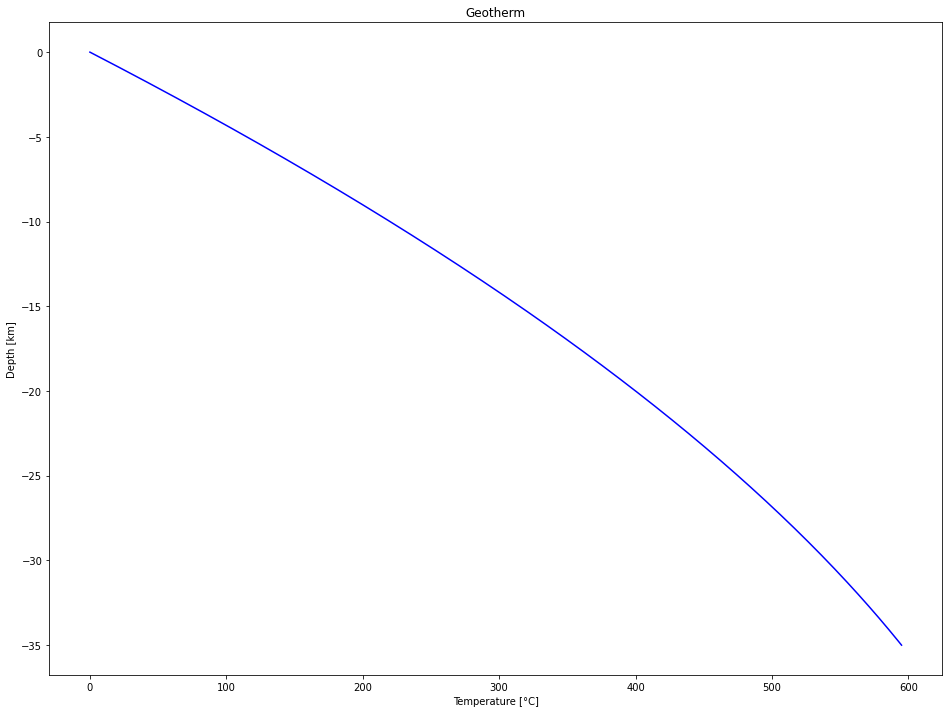

In [4]:
# ##############################################################
# Initial model
# ##############################################################
T = solve0(k, H, T0, q, n, dx)

figure(figsize=(16, 12))
plot(T, -x / 1000, "b-")
title('Geotherm')
xlabel('Temperature [°C]')
ylabel('Depth [km]')
show()

In [5]:

# ##############################################################
# Main
# ##############################################################

# Copy for compare plot
T_zero = T.copy()
x_zero = x.copy()

# Point in 25km. 
h_point = [25_000]
T_point = [T[250]]

h = h0
dt = 10_000 * ysec  # Time step 10_000y in seconds

for i in range(2000):
    h, dh = calculate_thickness(h, dt)
    
    x_old, x = x.copy(), linspace(0, h, n) # swap
    
    T = solve1(k=k, H=H, c=c, rho=rho, T=interp(x, x_old, T), q=q, dx= (h / (n - 1)), dt=dt)

    h_point_new = (h_point[-1] * exp(edot * dt)) - dh
    h_point.append(h_point_new)
    T_point.append(interp(h_point_new, x, T))

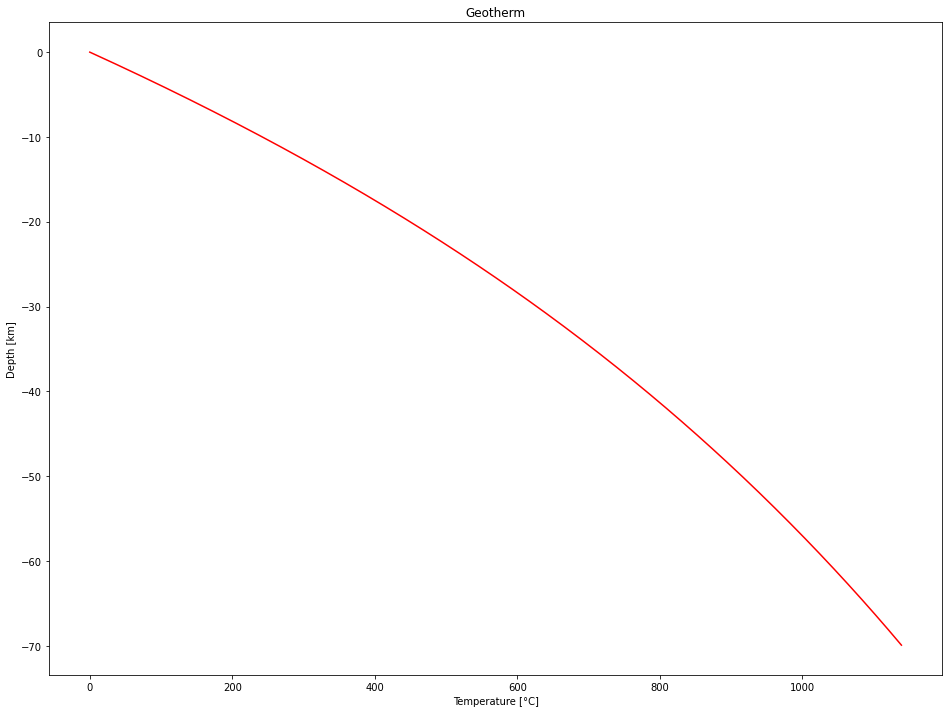

In [6]:
figure(figsize=(16, 12))
plot(T, -x / 1000, "r-")
title('Geotherm')
xlabel('Temperature [°C]')
ylabel('Depth [km]')
show()

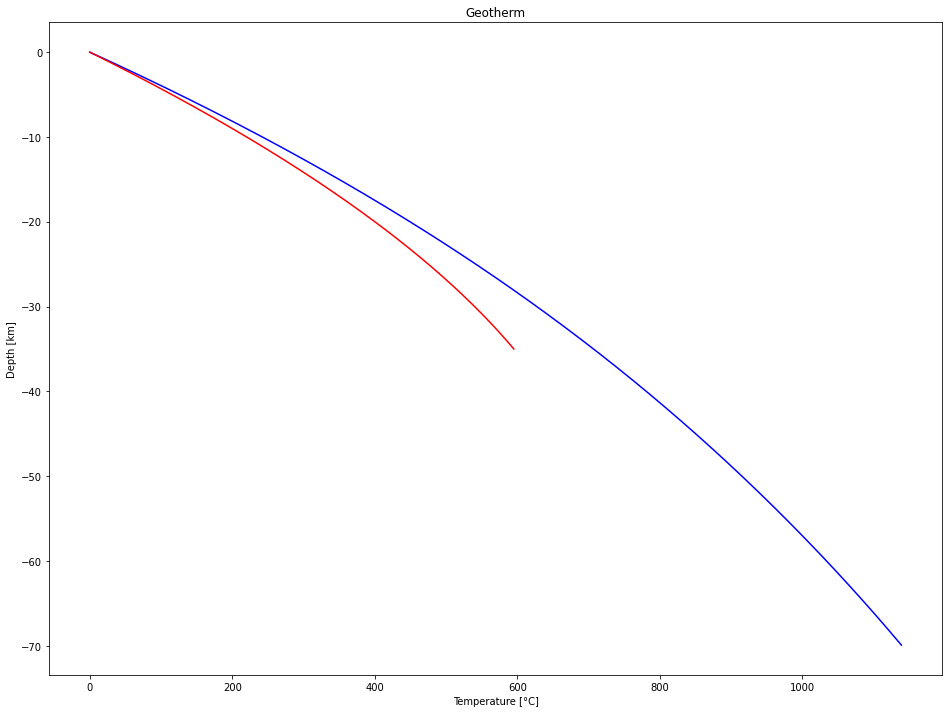

In [7]:
figure(figsize=(16, 12))
plot(T, -x / 1000, "b-")
plot(T_zero, -x_zero / 1000, "r-")
title('Geotherm')
xlabel('Temperature [°C]')
ylabel('Depth [km]')
show()


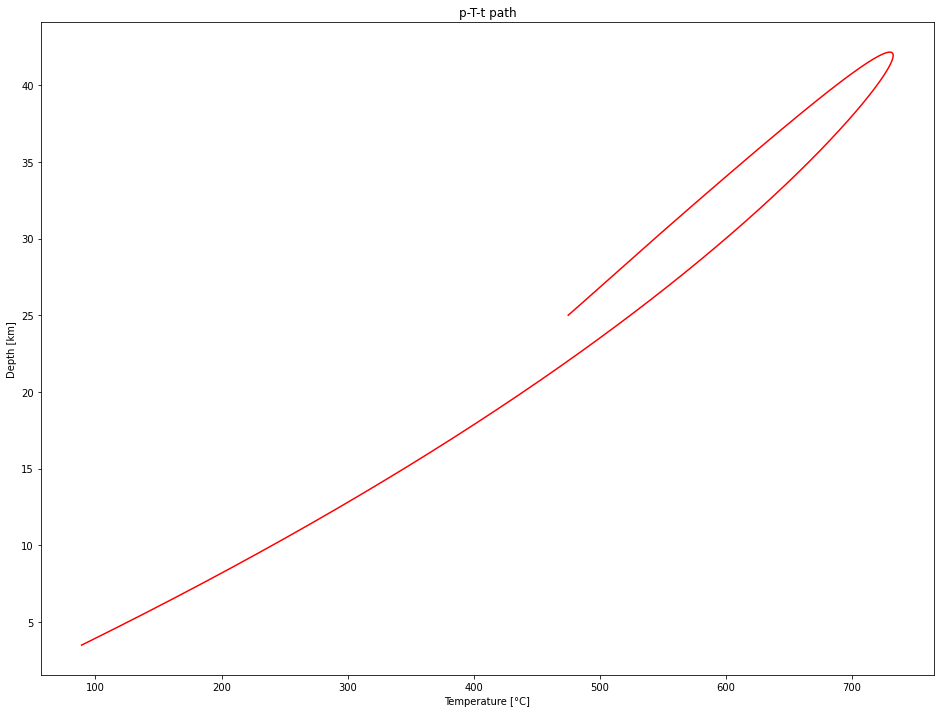

In [8]:
figure(figsize=(16, 12))
plot(array(T_point), array(h_point) / 1000, "r-")
title('p-T-t path')
xlabel('Temperature [°C]')
ylabel('Depth [km]')
show()
